In [8]:
import pandas as pd
import json, os

# Config file
with open('cfg.json') as json_file:
    cfg = json.load(json_file)
kmeans = pd.read_csv(os.path.join(cfg['WORKING_DATA_DIR'], 'Processed/Intermediates/kmeans.csv'))
spectral = pd.read_csv(os.path.join(cfg['WORKING_DATA_DIR'], 'Processed/Intermediates/spectral.csv'))
agg = pd.read_csv(os.path.join(cfg['WORKING_DATA_DIR'], 'Processed/Intermediates/agglomerative.csv'))
merged = pd.merge(kmeans, agg, how='inner', on='mrn_csn_pair')

In [9]:
# Config file
with open('cfg.json') as json_file:
    cfg = json.load(json_file)

# Get ts freshed data
ts_freshed_dir = os.path.join(cfg['WORKING_DATA_DIR'], 'Processed/complete_24h.csv')
dat = pd.read_csv(ts_freshed_dir)
dat['cluster'] = dat['mrn_csn_pair'].apply(lambda x: 1 if x in merged['mrn_csn_pair'].tolist() else 0)
outcome_los = dat[['mrn_csn_pair', 'LOS']]

In [15]:
import sqlite3

merged_dir = os.path.join(cfg['WORKING_DATA_DIR'], 'Processed/Merged.db')
merged_conn = sqlite3.connect(merged_dir)

m = pd.read_sql_query('SELECT * FROM outcomes', merged_conn)
m['cluster'] = m['mrn_csn_pair'].apply(lambda x: 1 if x in merged['mrn_csn_pair'].tolist() else 0)
m['time_in_hospital'] = m['time_in_hospital'].copy() / 1440

OperationalError: unable to open database file

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt

Text(0, 0.5, 'LOS (days)')

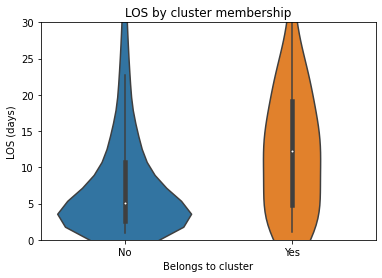

In [41]:
sns.violinplot(data=m, x='cluster', y='time_in_hospital', ci=95)
plt.ylim(0,30)
plt.title('LOS by cluster membership')
plt.xlabel('Belongs to cluster')
plt.xticks([0,1], ['No','Yes'])
plt.ylabel('LOS (days)')

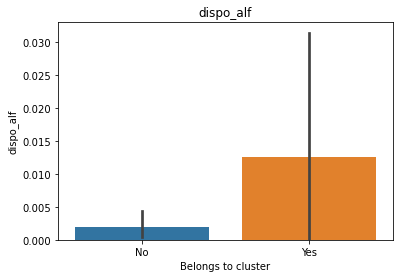

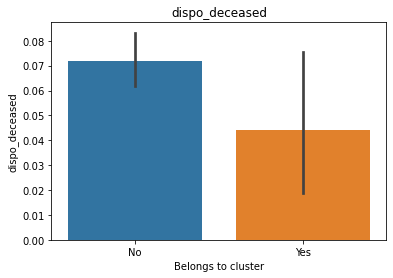

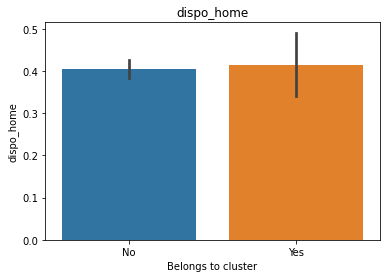

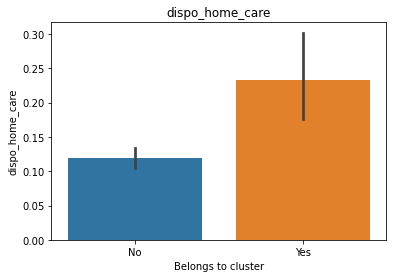

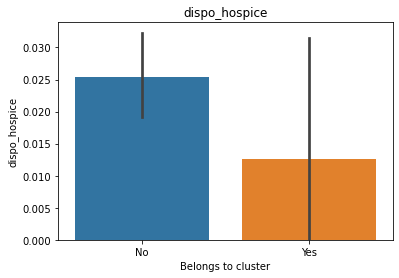

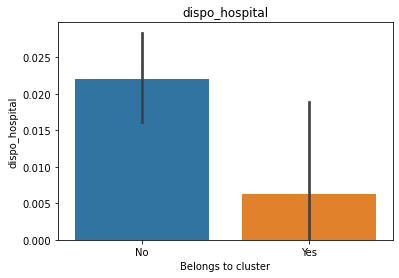

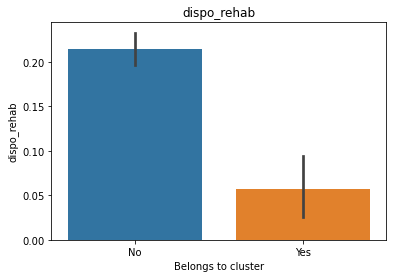

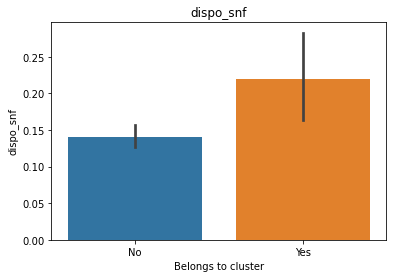

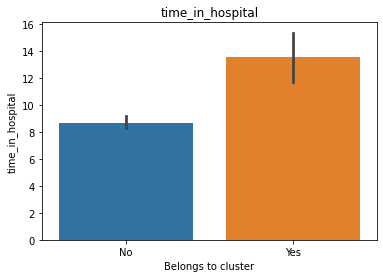

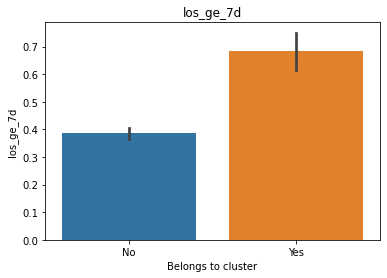

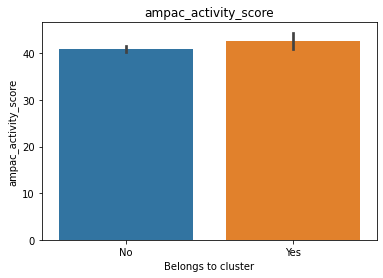

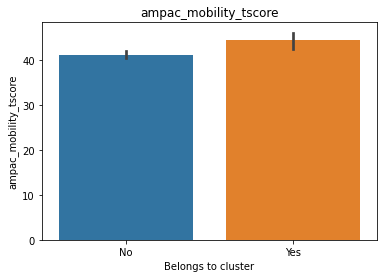

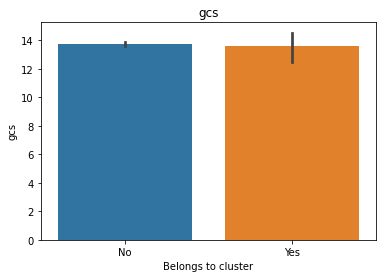

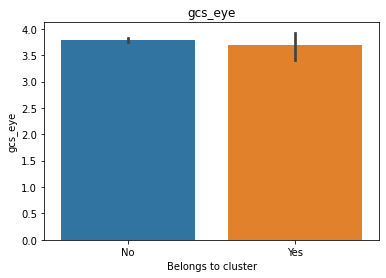

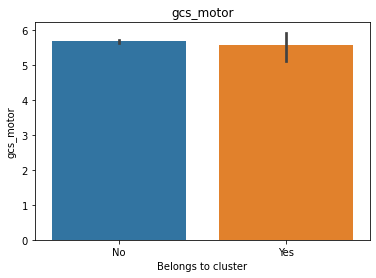

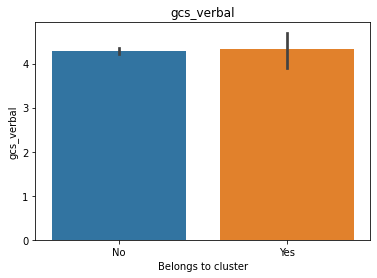

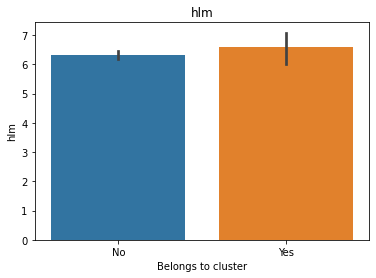

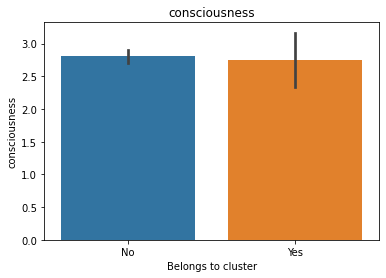

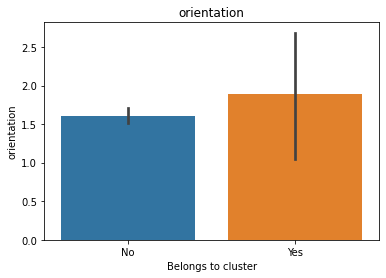

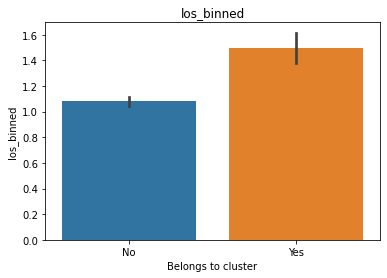

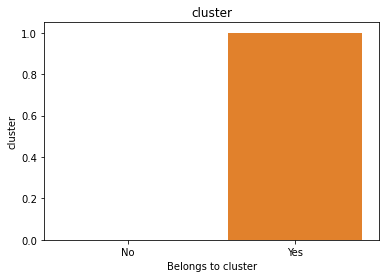

In [42]:
for c in m.columns[1:]:
    sns.barplot(data=m, y=c, x='cluster')
    plt.title(c)
    plt.xlabel('Belongs to cluster')
    plt.xticks([0,1], ['No','Yes'])
    plt.show()

AUC 0.6488093861981274
Accuracy 0.6196130167106421
Precision 0.12108108108108108
Recall 0.6829268292682927
F1 0.2056932966023875


<ipython-input-44-5b331081a1b4>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outcome_los['cluster'] = outcome_los['mrn_csn_pair'].apply(lambda x: 1 if x in merged['mrn_csn_pair'].tolist() else 0)


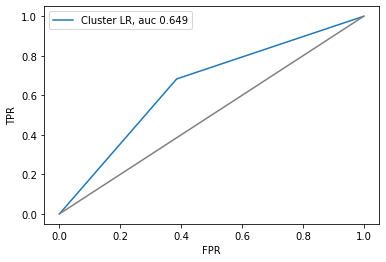

In [44]:
##### Logistic Regression -- Cluster only #####
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import *
import matplotlib.pyplot as plt

outcome_los['cluster'] = outcome_los['mrn_csn_pair'].apply(lambda x: 1 if x in merged['mrn_csn_pair'].tolist() else 0)

logr = LogisticRegression().fit(outcome_los[['cluster']], outcome_los['LOS'])
preds = logr.predict(outcome_los[['cluster']])
logr.score(outcome_los[['cluster']], outcome_los['LOS'])
print('AUC',roc_auc_score(preds,outcome_los['LOS']))
print('Accuracy',accuracy_score(preds,outcome_los['LOS']))
print('Precision',precision_score(preds,outcome_los['LOS']))
print('Recall',recall_score(preds,outcome_los['LOS']))
print('F1',f1_score(preds,outcome_los['LOS']))

fpr, tpr, thresh = roc_curve(preds, outcome_los['LOS'])
plt.plot(fpr,tpr)
plt.plot([0,1],[0,1], color='gray')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend(['Cluster LR, auc 0.649'])

AUC 0.9763704315472467
Accuracy 0.996042216358839
Precision 0.9939024390243902
Recall 0.9532163742690059
F1 0.973134328358209


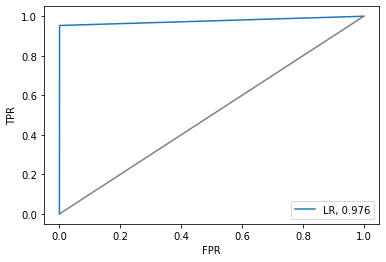

In [45]:
##### Logistic Regression #####
from scipy.stats import ttest_ind, chi2_contingency
from sklearn import preprocessing
X = dat.drop(columns=['Unnamed: 0', 'LOS', 'mrn_csn_pair', 'cluster'])
X
y = dat['mrn_csn_pair'].apply(lambda x: 1 if x in merged['mrn_csn_pair'].tolist() else 0)

mms = preprocessing.MinMaxScaler()
X = mms.fit_transform(X)

lr = LogisticRegression(max_iter=1000).fit(X,y)
preds = lr.predict(X)
print('AUC',roc_auc_score(preds,y))
print('Accuracy',accuracy_score(preds,y))
print('Precision',precision_score(preds,y))
print('Recall',recall_score(preds,y))
print('F1',f1_score(preds,y))

fpr, tpr, thresh = roc_curve(preds,y)
plt.plot(fpr,tpr)
plt.plot([0,1],[0,1], color='gray')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend(['LR, 0.976'])

In [46]:
##### Show log reg coeffs plot #####
lr_df = pd.DataFrame.from_dict({'name':dat.drop(columns=['Unnamed: 0', 'LOS', 'mrn_csn_pair', 'cluster']).columns, 'coef': lr.coef_[0]})

lr_df = lr_df.iloc[lr_df['coef'].abs().argsort()].iloc[::-1]

def getCat(x):
    if 'sbp' in x:
        return 'sbp'
    elif 'dbp' in x:
        return 'dbp'
    elif 'pulse_ox' in x:
        return 'pulse_ox'
    elif 'pulse' in x:
        return 'pulse'
    elif 'hx_' in x:
        return 'hx'
    elif 'pl_' in x:
        return 'pl'
    else:
        return 'other'
    
lr_df['cat'] = lr_df['name'].apply(lambda x: getCat(x))
lr_df['abs'] = lr_df['coef'].abs()
lr_df.to_csv('lr_df.csv')

Text(0, 0.5, 'Abs value of coefficient')

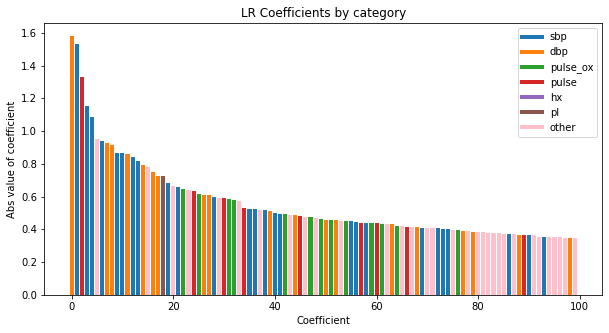

In [47]:
n = 100
fig = plt.figure(figsize=(10,5))
colors = {
    'sbp': 'tab:blue',
    'dbp': 'tab:orange',
    'pulse_ox': 'tab:green',
    'pulse': 'tab:red',
    'hx': 'tab:purple',
    'pl': 'tab:brown',
    'other': 'pink'
}
plt.bar(data=lr_df.head(n), x=range(n), height='abs', color= [colors[x] for x in lr_df.head(n)['cat'].tolist()])


lines =  ['sbp', 'dbp', 'pulse_ox', 'pulse', 'hx', 'pl', 'other']
from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color=colors[x], lw=4) for x in lines]


plt.legend(custom_lines, lines)
plt.title('LR Coefficients by category')
plt.xlabel('Coefficient')
plt.ylabel('Abs value of coefficient')